In [1]:
import os
import sys

sys.path.append('..')

from models import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn import metrics

le = LabelEncoder()

df = pd.read_hdf("../data_extract/features_dataset_2b.h5")

In [2]:
NUM_PEOPLE = 20
df = df.loc[df['id']<NUM_PEOPLE]

In [3]:
flist = ["mfcc{}".format(i) for i in range(14)]

df_train, df_cross, df_test = get_partitions_2(df,train_per=0.3,cross_per=0.6,test_per=0.1)

obj = MultiGauss(flist)
obj.fit(df_train)

In [4]:
# obj.predict_df(df_cross)

In [5]:
orig, pred = obj.get_results(df_test)
conf_arr = metrics.confusion_matrix(orig['id'], pred['id'])

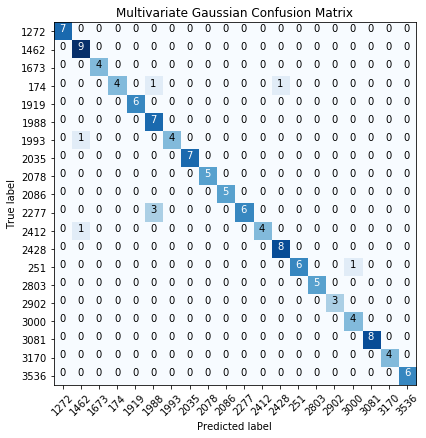

In [20]:
merged_inner = pd.merge(left=orig,right=df[['id','pid','pname']], left_on='id', right_on='id')

np.set_printoptions(precision=2)
plt.figure(figsize=(6,6),edgecolor='k')
utils.plot_confusion_matrix(conf_arr, classes=merged_inner['pid'].drop_duplicates(), title='Multivariate Gaussian Confusion Matrix');
plt.show()

In [8]:
clist = ["chroma{}".format(i) for i in range(12)]
lclist = ["lc{}".format(i) for i in range(12)]
df[lclist] = np.log(df[clist])
flist = ["mfcc{}".format(i) for i in range(14)]
df_train, df_cross, df_test = get_partitions_2(df,train_per=0.3,cross_per=0.6,test_per=0.1)
obj2 = SVM(flist)
obj2.fit(df_train)
orig2, pred2 = obj2.get_results(df_test)
conf_arr2 = metrics.confusion_matrix(orig2['id'], pred2['id'])

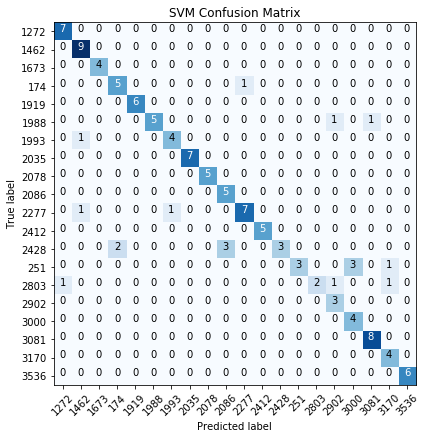

In [19]:
merged_inner = pd.merge(left=orig,right=df[['id','pid','pname']], left_on='id', right_on='id')

np.set_printoptions(precision=2)
plt.figure(figsize=(6,6),edgecolor='k')
utils.plot_confusion_matrix(conf_arr2, classes=merged_inner['pid'].drop_duplicates(), title='SVM Confusion Matrix');
plt.show()